# Import Libraries

In [1]:
!pip install hydra-core

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pycaret.regression import *

import mlflow
import mlflow.sklearn
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import os
import hydra
from omegaconf import DictConfig
from hydra.experimental import compose, initialize_config_dir

# Data Preprocessing
1. Drop Duplicates
2. Change month data type
3. Sample down data as jupyter will crash during model tuning
4. pycaret

### Pycaret Processing
1. target is resale price
2. train size of 0.8
3. transformation and normalize set to true to normalize data
4. remove outliers
5. 5 kfold
6. ignore features not required
- block number can be repeated throughout different towns and it will not indicate a higher or lower price
- latitude and longitude not required as users will not always know the exact coordinates of their house
7. bin postal code since it should be categorical and to avoid too many unique values
8. Explicity set month to as date feature

# Train Model
1. Drop models that will take too long/ crash jupyter notebook
2. Tune Model
4. Evaluate Model
5. Save Pipeline
6. Register Model

All parameters in process_RJ.yaml: {'data': {'raw': '../../data/raw/01_hdb_resale_transactions.csv', 'ppath': '../../data/processed/'}, 'setup': {'target': 'resale_price', 'trainsize': 0.8, 'transform': True, 'norm': True, 'session': 123, 'logexp': True, 'expname': 'hdb_experiment', 'rmoutlier': True, 'fold': 10, 'date': 'month', 'bin': 'postal_code', 'sample': 0.6, 'ignore': ['block', 'latitude', 'longitude']}}


,Description,Value
0,Session id,123
1,Target,resale_price
2,Target type,Regression
3,Original data shape,"(116326, 15)"
4,Transformed data shape,"(111673, 56)"
5,Transformed train set shape,"(88407, 56)"
6,Transformed test set shape,"(23266, 56)"
7,Ignore features,3
8,Numeric features,5
9,Date features,1


Numeric features: ['postal_code', 'floor_area_sqm', 'lease_commence_date', 'cbd_dist', 'min_dist_mrt']
Categorical features: ['street_name', 'town', 'flat_type', 'storey_range', 'flat_model']
Date features: ['month']
Data was processed and written at ../../data/processed/hdb_processed.csv.


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,24108.2570,1136455767.6581,33706.5460,0.9574,0.0675,0.0515,2.4640
et,Extra Trees Regressor,22418.1440,1138768644.1415,33717.7901,0.9573,0.0650,0.0472,26.6580
rf,Random Forest Regressor,22605.0390,1164175661.5401,34107.5199,0.9564,0.0648,0.0473,29.4130
dt,Decision Tree Regressor,30738.6329,2136283409.5140,46207.7311,0.9199,0.0890,0.0644,1.7760
knn,K Neighbors Regressor,36241.6773,2869922816.0000,53565.9691,0.8924,0.1003,0.0741,4.6480
gbr,Gradient Boosting Regressor,38690.1639,2926311666.2748,54092.3726,0.8903,0.1066,0.0823,7.3670
lr,Linear Regression,51391.7864,4433394257.7041,66582.6551,0.8338,0.1634,0.1156,6.4030
ridge,Ridge Regression,54453.3115,5041200268.2309,70999.5081,0.8110,0.1650,0.1218,2.3100
br,Bayesian Ridge,54452.5293,5041269156.4593,70999.9932,0.8110,0.1650,0.1218,2.5700
lasso,Lasso Regression,54453.2998,5041205356.5423,70999.5439,0.8110,0.1650,0.1218,6.2990


LGBMRegressor(random_state=123)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,19499.4885,774933069.7650,27837.6197,0.9714,0.0567,0.0419
1,20178.5509,819766574.1623,28631.5660,0.9695,0.0587,0.0435
2,19543.1054,760792738.3208,27582.4716,0.9718,0.0559,0.0421
3,20011.8827,851102867.5598,29173.6674,0.9682,0.0574,0.0430
4,20046.1613,800366678.1658,28290.7525,0.9703,0.0565,0.0426
5,19508.0790,809829245.3253,28457.4989,0.9688,0.0562,0.0418
6,19663.1297,768261108.2007,27717.5235,0.9708,0.0565,0.0425
7,19719.7555,771373936.3518,27773.6194,0.9709,0.0563,0.0423
8,19726.2036,772230088.2627,27789.0282,0.9710,0.0566,0.0424


Fitting 10 folds for each of 10 candidates, totalling 100 fits
LGBMRegressor(bagging_fraction=0.6, bagging_freq=2, feature_fraction=0.4,
              min_child_samples=41, min_split_gain=0.9, n_estimators=260,
              num_leaves=70, random_state=123, reg_alpha=2, reg_lambda=3)


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,19816.3023,775608387.8293,27849.7466,0.9713,0.0567,0.0425


                   street_name           town  postal_code      month  \
8176    CHOA CHU KANG AVENUE 4  CHOA CHU KANG       680451 2015-06-01   
121975           PUNGGOL DRIVE        PUNGGOL       822666 2020-11-01   
176303   JURONG WEST STREET 64    JURONG WEST       643677 2022-11-01   
135799       CLEMENTI AVENUE 4       CLEMENTI       123311 2021-05-01   
53108      WOODLANDS STREET 32      WOODLANDS       730345 2017-10-01   
...                        ...            ...          ...        ...   
183096    ANG MO KIO AVENUE 10     ANG MO KIO       560421 2023-02-01   
27422    NEW UPPER CHANGI ROAD          BEDOK       461057 2016-07-01   
193033           MONTREAL LINK      SEMBAWANG       753590 2023-06-01   
31035           DOVER CRESCENT     QUEENSTOWN       132028 2016-09-01   
38753   CHOA CHU KANG AVENUE 1  CHOA CHU KANG       680130 2017-02-01   

       flat_type storey_range  floor_area_sqm         flat_model  \
8176      4 ROOM     16 TO 18           104.0  Premium 

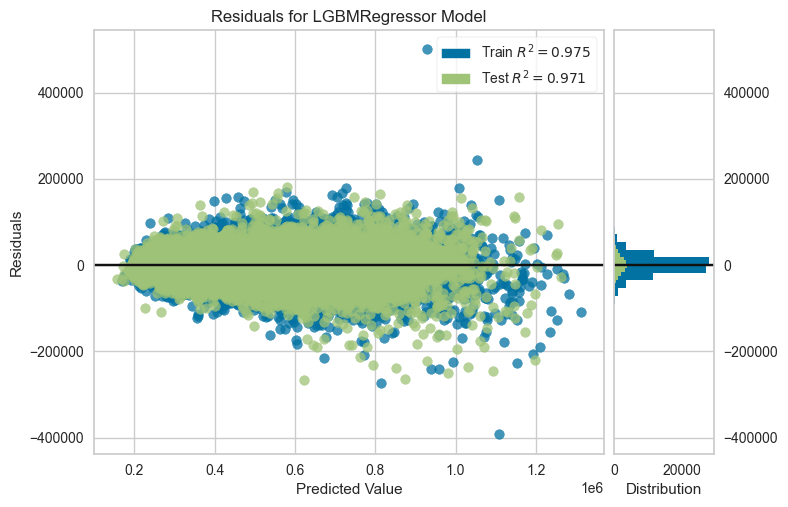

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded


Registered model 'hdb_LIGHTGBMmodel' already exists. Creating a new version of this model...
2023/08/21 18:56:50 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: hdb_LIGHTGBMmodel, version 2
Created version '2' of model 'hdb_LIGHTGBMmodel'.


In [3]:
def process_train():
    """Function to process the data"""
    
    # Specify the root directory where your MLOps project is located
    root_directory = "C:/Github/MLOPs_WebApp/MLOps_Assignment"

    # Construct the absolute path to the configuration directory
    config_dir = os.path.normpath(os.path.join(root_directory, "config", "process"))

    # Initialize the Hydra config directory
    initialize_config_dir(config_dir=config_dir)

    # Load the Hydra configuration
    config = compose(config_name="process_RJ")
    print('All parameters in process_RJ.yaml: ' + str(config))

    # Load raw data
    hdb = pd.read_csv(config.data.raw)

    # Remove duplicates
    hdb_nodup = hdb.drop_duplicates()

    # Convert 'month' column to datetime
    hdb_nodup['month'] = pd.to_datetime(hdb_nodup['month'], format='%Y-%m')

    # Sample the data based on the provided configuration
    hdb_sampled = hdb_nodup.sample(frac=config.setup.sample, random_state=123)

    # Perform PyCaret setup
    hdbsetup = setup(
        data=hdb_sampled,
        target=config.setup.target,
        train_size=config.setup.trainsize,
        transformation=config.setup.transform,
        normalize=config.setup.norm,
        session_id=config.setup.session,
        log_experiment=config.setup.logexp,
        experiment_name=config.setup.expname,
        remove_outliers=config.setup.rmoutlier,
        fold=config.setup.fold,
        ignore_features=config.setup.ignore,
        bin_numeric_features=[config.setup.bin],
        date_features=[config.setup.date]
    )

    # Print features information
    print(f'Numeric features: {hdbsetup._fxs["Numeric"]}')
    print(f'Categorical features: {hdbsetup._fxs["Categorical"]}')
    print(f'Date features: {hdbsetup._fxs["Date"]}')

    # Get transformed dataset
    df = hdbsetup.get_config('dataset_transformed')
    # print('Processed Data: ', df)

    # Save processed data
    file_name = 'hdb_processed.csv'
    full_file = os.path.join(config.data.ppath, file_name)
    df.to_csv(full_file, index=False)
    
    print(f'Data was processed and written at {full_file}.')

    # Compare models (excluding specified models)
    best = compare_models()
    print(best)

    # Tune models
    tuned_best = tune_model(best, return_tuner=True) 
    best_tuned_model = tuned_best[0]  # Extract the best tuned model from the tuple
    print(best_tuned_model)

    # predict on test set
    hdb_pred = predict_model(best_tuned_model)
    print(hdb_pred)
    
    plot_model(best_tuned_model, plot= 'residuals')
    evaluate_model(best_tuned_model)

    # SAVE PIPELINE
    # finalize the model
    finalized = finalize_model(best_tuned_model)

    # # save model to disk
    save_model(finalized, 'hdb_pipeline_final3')
    # load pipeline
    loaded_best_pipeline = load_model('hdb_pipeline_final3')

    # MODEL REGISTRATION
    # Calculate evaluation metrics
    y_true = hdb_pred['resale_price']
    y_pred = hdb_pred['prediction_label']
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    mlflow.end_run()
    # Register the pipeline with MLflow
    with mlflow.start_run() as run:
        # Log the experiment name and run ID
        mlflow.set_experiment('Final_HDB')
        mlflow.log_param('experiment_name', 'Final_HDB')
        mlflow.log_param('run_id', run.info.run_id)
        
        mlflow.log_param('train_size', 0.8)
        mlflow.log_param('transformation', True)
        mlflow.log_param('normalize', True)
        mlflow.log_param('remove_outliers', True)
        mlflow.log_param('fold', 10)
        
        # Log metrics
        mlflow.log_metric('MAE', mae)
        mlflow.log_metric('MSE', mse)
        mlflow.log_metric('RMSE', rmse)
        mlflow.log_metric('R2', r2)
        
        
        # Log the pipeline object using mlflow.sklearn
        mlflow.sklearn.log_model(sk_model=best_tuned_model, registered_model_name='hdb_LIGHTGBMmodel', artifact_path='sk_model')
    


process_train()

All parameters in process_RJ.yaml: {'data': {'raw': '../../data/raw/01_hdb_resale_transactions.csv', 'ppath': '../../data/processed/'}, 'setup': {'target': 'resale_price', 'trainsize': 0.8, 'transform': True, 'norm': True, 'session': 123, 'logexp': True, 'expname': 'hdb_experiment', 'rmoutlier': True, 'fold': 10, 'date': 'month', 'bin': 'postal_code', 'sample': 0.6, 'ignore': ['block', 'latitude', 'longitude']}}


,Description,Value
0,Session id,123
1,Target,resale_price
2,Target type,Regression
3,Original data shape,"(116326, 15)"
4,Transformed data shape,"(111673, 56)"
5,Transformed train set shape,"(88407, 56)"
6,Transformed test set shape,"(23266, 56)"
7,Ignore features,3
8,Numeric features,5
9,Date features,1


Traceback (most recent call last):
  File "C:\Users\Shermaine\.conda\envs\mlops\lib\site-packages\mlflow\store\tracking\file_store.py", line 299, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
  File "C:\Users\Shermaine\.conda\envs\mlops\lib\site-packages\mlflow\store\tracking\file_store.py", line 392, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "C:\Users\Shermaine\.conda\envs\mlops\lib\site-packages\mlflow\store\tracking\file_store.py", line 1239, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "C:\Users\Shermaine\.conda\envs\mlops\lib\site-packages\mlflow\store\tracking\file_store.py", line 1232, in _read_helper
    result = read_yaml(root, file_name)
  File "C:\Users\Shermaine\.conda\envs\mlops\lib\site-packages\mlflow\utils\file_utils.py", line 227, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exception

Numeric features: ['postal_code', 'floor_area_sqm', 'lease_commence_date', 'cbd_dist', 'min_dist_mrt']
Categorical features: ['street_name', 'town', 'flat_type', 'storey_range', 'flat_model']
Date features: ['month']
Data was processed and written at ../../data/processed/hdb_processed.csv.


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,35947.6367,2788803584.0000,52809.1250,0.8970,0.0994,0.0736
1,36687.1445,2940452864.0000,54225.9414,0.8907,0.1017,0.0749
2,36270.8281,2926459136.0000,54096.7578,0.8914,0.1006,0.0740
3,36547.7578,2948587520.0000,54300.8984,0.8898,0.1010,0.0746
4,36996.8320,3028273152.0000,55029.7461,0.8875,0.1019,0.0750
5,35661.2344,2792499968.0000,52844.1094,0.8923,0.0992,0.0729
6,36183.9805,2853439488.0000,53417.5938,0.8914,0.1005,0.0745
7,36127.2461,2831056896.0000,53207.6758,0.8931,0.1002,0.0742
8,35695.3516,2743734016.0000,52380.6641,0.8969,0.0984,0.0731


Traceback (most recent call last):
  File "C:\Users\Shermaine\.conda\envs\mlops\lib\site-packages\mlflow\store\tracking\file_store.py", line 299, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
  File "C:\Users\Shermaine\.conda\envs\mlops\lib\site-packages\mlflow\store\tracking\file_store.py", line 392, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "C:\Users\Shermaine\.conda\envs\mlops\lib\site-packages\mlflow\store\tracking\file_store.py", line 1239, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "C:\Users\Shermaine\.conda\envs\mlops\lib\site-packages\mlflow\store\tracking\file_store.py", line 1232, in _read_helper
    result = read_yaml(root, file_name)
  File "C:\Users\Shermaine\.conda\envs\mlops\lib\site-packages\mlflow\utils\file_utils.py", line 227, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exception

KNeighborsRegressor(n_jobs=-1)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,33093.8579,2417083701.1547,49163.8455,0.9107,0.0914,0.0676
1,33924.9926,2494416697.5021,49944.1358,0.9073,0.0935,0.0695
2,33424.5647,2513959325.1496,50139.3989,0.9067,0.0925,0.0683
3,34049.6323,2579973901.6898,50793.4435,0.9036,0.0944,0.0698
4,34211.8797,2626208013.4675,51246.5415,0.9024,0.0936,0.0694
5,32999.6585,2440436605.4710,49400.7754,0.9058,0.0919,0.0676
6,33133.6641,2417300245.7282,49166.0477,0.9080,0.0921,0.0685
7,33324.9879,2410129288.4195,49093.0676,0.9090,0.0921,0.0685
8,33169.4104,2385567130.0944,48842.2679,0.9104,0.0911,0.0679


Fitting 10 folds for each of 10 candidates, totalling 100 fits


Traceback (most recent call last):
  File "C:\Users\Shermaine\.conda\envs\mlops\lib\site-packages\mlflow\store\tracking\file_store.py", line 299, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
  File "C:\Users\Shermaine\.conda\envs\mlops\lib\site-packages\mlflow\store\tracking\file_store.py", line 392, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "C:\Users\Shermaine\.conda\envs\mlops\lib\site-packages\mlflow\store\tracking\file_store.py", line 1239, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "C:\Users\Shermaine\.conda\envs\mlops\lib\site-packages\mlflow\store\tracking\file_store.py", line 1232, in _read_helper
    result = read_yaml(root, file_name)
  File "C:\Users\Shermaine\.conda\envs\mlops\lib\site-packages\mlflow\utils\file_utils.py", line 227, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exception

KNeighborsRegressor(metric='manhattan', n_jobs=-1, n_neighbors=13,
                    weights='distance')


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,33649.6706,2442026214.6272,49416.8616,0.9096,0.0922,0.0687


                   street_name           town  postal_code      month  \
8176    CHOA CHU KANG AVENUE 4  CHOA CHU KANG       680451 2015-06-01   
121975           PUNGGOL DRIVE        PUNGGOL       822666 2020-11-01   
176303   JURONG WEST STREET 64    JURONG WEST       643677 2022-11-01   
135799       CLEMENTI AVENUE 4       CLEMENTI       123311 2021-05-01   
53108      WOODLANDS STREET 32      WOODLANDS       730345 2017-10-01   
...                        ...            ...          ...        ...   
183096    ANG MO KIO AVENUE 10     ANG MO KIO       560421 2023-02-01   
27422    NEW UPPER CHANGI ROAD          BEDOK       461057 2016-07-01   
193033           MONTREAL LINK      SEMBAWANG       753590 2023-06-01   
31035           DOVER CRESCENT     QUEENSTOWN       132028 2016-09-01   
38753   CHOA CHU KANG AVENUE 1  CHOA CHU KANG       680130 2017-02-01   

       flat_type storey_range  floor_area_sqm         flat_model  \
8176      4 ROOM     16 TO 18           104.0  Premium 

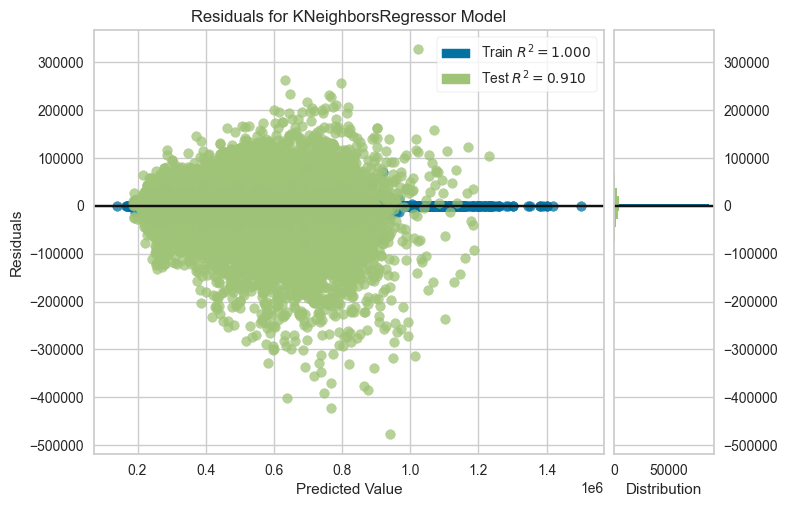

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Traceback (most recent call last):
  File "C:\Users\Shermaine\.conda\envs\mlops\lib\site-packages\mlflow\store\tracking\file_store.py", line 299, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
  File "C:\Users\Shermaine\.conda\envs\mlops\lib\site-packages\mlflow\store\tracking\file_store.py", line 392, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "C:\Users\Shermaine\.conda\envs\mlops\lib\site-packages\mlflow\store\tracking\file_store.py", line 1239, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "C:\Users\Shermaine\.conda\envs\mlops\lib\site-packages\mlflow\store\tracking\file_store.py", line 1232, in _read_helper
    result = read_yaml(root, file_name)
  File "C:\Users\Shermaine\.conda\envs\mlops\lib\site-packages\mlflow\utils\file_utils.py", line 227, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exception

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded


In [2]:
def process_train():
    """Function to process the data"""
    
    # Specify the root directory where your MLOps project is located
    root_directory = "C:/Github/MLOPs_WebApp/MLOps_Assignment"

    # Construct the absolute path to the configuration directory
    config_dir = os.path.normpath(os.path.join(root_directory, "config", "process"))

    # Initialize the Hydra config directory
    initialize_config_dir(config_dir=config_dir)

    # Load the Hydra configuration
    config = compose(config_name="process_RJ")
    print('All parameters in process_RJ.yaml: ' + str(config))

    # Load raw data
    hdb = pd.read_csv(config.data.raw)

    # Remove duplicates
    hdb_nodup = hdb.drop_duplicates()

    # Convert 'month' column to datetime
    hdb_nodup['month'] = pd.to_datetime(hdb_nodup['month'], format='%Y-%m')

    # Sample the data based on the provided configuration
    hdb_sampled = hdb_nodup.sample(frac=config.setup.sample, random_state=123)

    # Perform PyCaret setup
    hdbsetup = setup(
        data=hdb_sampled,
        target=config.setup.target,
        train_size=config.setup.trainsize,
        transformation=config.setup.transform,
        normalize=config.setup.norm,
        session_id=config.setup.session,
        log_experiment=config.setup.logexp,
        experiment_name=config.setup.expname,
        remove_outliers=config.setup.rmoutlier,
        fold=config.setup.fold,
        ignore_features=config.setup.ignore,
        bin_numeric_features=[config.setup.bin],
        date_features=[config.setup.date]
    )

    # Print features information
    print(f'Numeric features: {hdbsetup._fxs["Numeric"]}')
    print(f'Categorical features: {hdbsetup._fxs["Categorical"]}')
    print(f'Date features: {hdbsetup._fxs["Date"]}')

    # Get transformed dataset
    df = hdbsetup.get_config('dataset_transformed')
    # print('Processed Data: ', df)

    # Save processed data
    file_name = 'hdb_processed.csv'
    full_file = os.path.join(config.data.ppath, file_name)
    #df.to_csv(full_file, index=False)
    
    print(f'Data was processed and written at {full_file}.')

    # Compare models (excluding specified models)
    best = create_model('knn')
    print(best)

    # Tune models
    tuned_best = tune_model(best, return_tuner=True) 
    best_tuned_model = tuned_best[0]  # Extract the best tuned model from the tuple
    print(best_tuned_model)

    # predict on test set
    hdb_pred = predict_model(best_tuned_model)
    print(hdb_pred)
    
    plot_model(best_tuned_model, plot= 'residuals')
    evaluate_model(best_tuned_model)

    # SAVE PIPELINE
    # finalize the model
    finalized = finalize_model(best_tuned_model)

    # # save model to disk
    save_model(finalized, 'hdb_pipeline_final3')
    # load pipeline
    loaded_best_pipeline = load_model('hdb_pipeline_final3')


process_train()